<a href="https://colab.research.google.com/github/sriwulandari13/Data-Visualization/blob/main/Case_Study_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import datetime as datetime
import matplotlib.dates as dates
import matplotlib.pyplot as plt

from contextlib import contextmanager
from time import time
from tqdm import tqdm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

import datetime
from datetime import date

In [2]:
df = pd.read_csv('covid19.csv')
df.head(20)

Date Location ISO Code     Location  New Cases  New Deaths  \
0   3/1/2020             ID-JK  DKI Jakarta          2           0   
1   3/2/2020             ID-JK  DKI Jakarta          2           0   
2   3/2/2020               IDN    Indonesia          2           0   
3   3/2/2020             ID-RI         Riau          1           0   
4   3/3/2020             ID-JK  DKI Jakarta          2           0   
5   3/3/2020               IDN    Indonesia          0           0   
6   3/3/2020             ID-JB   Jawa Barat          1           1   
7   3/3/2020             ID-RI         Riau          0           0   
8   3/4/2020             ID-JK  DKI Jakarta          2           0   
9   3/4/2020               IDN    Indonesia          0           0   
10  3/4/2020             ID-JB   Jawa Barat          1           0   
11  3/4/2020             ID-RI         Riau          0           0   
12  3/5/2020             ID-JK  DKI Jakarta          0           1   
13  3/5/2020               IDN    Indonesia          0           0   
14  3/5/2020             ID-JB   Jawa Barat          1           0   
15  3/5/2020             ID-RI         Riau          0           0   
16  3/6/2020             ID-BT       Banten          1           0   
17  3/6/2020             ID-JK  DKI Jakarta          0           0   
18  3/6/2020               IDN    Indonesia          2           0   
19  3/6/2020             ID-JB   Jawa Barat          1           0   

    New Recovered  New Active Cases  Total Cases  Total Deaths  \
0               0                 2           39            20   
1               0                 2           41            20   
2               0                 2            2             0   
3               0                 1            2             0   
4               0                 2           43            20   
5               0                 0            2             0   
6               0                 0            1             1   
7               0                 0            2             0   
8               0                 2           45            20   
9               0                 0            2             0   
10              0                 1            2             1   
11              0                 0            2             0   
12              0                -1           45            21   
13              0                 0            2             0   
14              0                 1            3             1   
15              0                 0            2             0   
16              1                 0            1             5   
17              0                 0           45            21   
18              0                 2            4             0   
19              0                 1            4             1   

    Total Recovered  ...  Latitude New Cases per Million  \
0                41  ... -6.204699                  0.18   
1                41  ... -6.204699                  0.18   
2                 0  ... -0.789275                  0.01   
3                 3  ...  0.511648                  0.16   
4                41  ... -6.204699                  0.18   
5                 0  ... -0.789275                  0.00   
6                 8  ... -6.920432                  0.02   
7                 3  ...  0.511648                  0.00   
8                41  ... -6.204699                  0.18   
9                 0  ... -0.789275                  0.00   
10                8  ... -6.920432                  0.02   
11                3  ...  0.511648                  0.00   
12               41  ... -6.204699                  0.00   
13                0  ... -0.789275                  0.00   
14                8  ... -6.920432                  0.02   
15                3  ...  0.511648                  0.00   
16               74  ... -6.456736                  0.09   
17               41  ... -6.204699                  0.00   
18        

In [4]:
#ubah format tanggal
date2=[]
for item in df['Date']:
    item2=item.split('/')
    month=int(item2[0])
    day=int(item2[1])
    year=int(item2[2])
    date2+=[datetime.date(year,month,day)]
df['Date']=date2
df['Date']= pd.to_datetime(df['Date'])

In [5]:
#hapus kolom dg semua data null dan kolom yg tdk diperlukan
data = df.drop(['City or Regency','Location ISO Code', 'Province', 
                'Country', 'Continent', 'Island', 'Time Zone',
                'Special Status', 'Total Regencies', 'Total Cities',
                'Total Districts', 'Total Urban Villages',
                'Total Rural Villages', 'New Cases per Million',
                'Total Cases per Million', 'New Deaths per Million',
                'Total Deaths per Million', 'Case Fatality Rate',
                'Case Recovered Rate', 'Growth Factor of New Cases',
                'Growth Factor of New Deaths'], axis=1)
data = data.fillna(0)
data.head()

Date     Location  New Cases  New Deaths  New Recovered  \
0 2020-03-01  DKI Jakarta          2           0              0   
1 2020-03-02  DKI Jakarta          2           0              0   
2 2020-03-02    Indonesia          2           0              0   
3 2020-03-02         Riau          1           0              0   
4 2020-03-03  DKI Jakarta          2           0              0   

   New Active Cases  Total Cases  Total Deaths  Total Recovered  \
0                 2           39            20               41   
1                 2           41            20               41   
2                 2            2             0                0   
3                 1            2             0                3   
4                 2           43            20               41   

   Total Active Cases Location Level  Area (km2)  Population  \
0                 -22       Province         664    10846145   
1                 -20       Province         664    10846145   
2                   2        Country     1916907   265185520   
3                  -1       Province       87024     6074100   
4                 -18       Province         664    10846145   

   Population Density   Longitude  Latitude  Total Deaths per 100rb  
0            16334.31  106.836118 -6.204699                    0.18  
1            16334.31  106.836118 -6.204699                    0.18  
2              138.34  113.921327 -0.789275                    0.00  
3               69.80  101.805109  0.511648                    0.00  
4            16334.31  106.836118 -6.204699                    0.18

In [6]:
data.tail()

Date          Location  New Cases  New Deaths  New Recovered  \
21754 2021-12-02    Sulawesi Utara          2           0              0   
21755 2021-12-02    Sumatera Barat          4           0              0   
21756 2021-12-02  Sumatera Selatan          4           0              0   
21757 2021-12-02    Sumatera Utara          4           0              1   
21758 2021-12-03         Indonesia        245           8            328   

       New Active Cases  Total Cases  Total Deaths  Total Recovered  \
21754                 2        34715          1056            33566   
21755                 4        89849          2152            87605   
21756                 4        59937          3071            56830   
21757                 3       106045          2889           103061   
21758               -91      4257243        143858          4105680   

       Total Active Cases Location Level  Area (km2)  Population  \
21754                  93       Province       13892     2641884   
21755                  92       Province       42013     5519245   
21756                  36       Province       91592     8217551   
21757                  95       Province       72981    14874889   
21758                7705        Country     1916907   265185520   

       Population Density   Longitude  Latitude  Total Deaths per 100rb  
21754              190.17  124.521240  1.259638                   39.97  
21755              131.37  100.465062 -0.850253                   38.99  
21756               89.72  104.169465 -3.216212                   37.37  
21757              203.82   99.051964  2.191894                   19.42  
21758              138.34  113.921327 -0.789275                   54.25

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21759 entries, 0 to 21758
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    21759 non-null  datetime64[ns]
 1   Location                21759 non-null  object        
 2   New Cases               21759 non-null  int64         
 3   New Deaths              21759 non-null  int64         
 4   New Recovered           21759 non-null  int64         
 5   New Active Cases        21759 non-null  int64         
 6   Total Cases             21759 non-null  int64         
 7   Total Deaths            21759 non-null  int64         
 8   Total Recovered         21759 non-null  int64         
 9   Total Active Cases      21759 non-null  int64         
 10  Location Level          21759 non-null  object        
 11  Area (km2)              21759 non-null  int64         
 12  Population              21759 non-null  int64 

In [8]:
#ambil data u/ level province
data1 = data[data['Location Level'] != 'Country']
data1.head()

Date     Location  New Cases  New Deaths  New Recovered  \
0 2020-03-01  DKI Jakarta          2           0              0   
1 2020-03-02  DKI Jakarta          2           0              0   
3 2020-03-02         Riau          1           0              0   
4 2020-03-03  DKI Jakarta          2           0              0   
6 2020-03-03   Jawa Barat          1           1              0   

   New Active Cases  Total Cases  Total Deaths  Total Recovered  \
0                 2           39            20               41   
1                 2           41            20               41   
3                 1            2             0                3   
4                 2           43            20               41   
6                 0            1             1                8   

   Total Active Cases Location Level  Area (km2)  Population  \
0                 -22       Province         664    10846145   
1                 -20       Province         664    10846145   
3                  -1       Province       87024     6074100   
4                 -18       Province         664    10846145   
6                  -8       Province       35378    45161325   

   Population Density   Longitude  Latitude  Total Deaths per 100rb  
0            16334.31  106.836118 -6.204699                    0.18  
1            16334.31  106.836118 -6.204699                    0.18  
3               69.80  101.805109  0.511648                    0.00  
4            16334.31  106.836118 -6.204699                    0.18  
6             1276.55  107.603708 -6.920432                    0.00

In [9]:
newest = data1.drop_duplicates(subset='Location', keep="last")
newest.head()

Date          Location  New Cases  New Deaths  New Recovered  \
21364 2021-11-21         Gorontalo          1           0              0   
21617 2021-11-28      Maluku Utara          2           0              3   
21700 2021-12-01          Bengkulu          1           0              0   
21712 2021-12-01  Kalimantan Utara          1           0              0   
21714 2021-12-01    Kepulauan Riau          2           0              0   

       New Active Cases  Total Cases  Total Deaths  Total Recovered  \
21364                 1        11834           460            11374   
21617                -1        12101           303            11757   
21700                 1        23104           473            22612   
21712                 1        35885           811            35039   
21714                 2        53884          1748            52120   

       Total Active Cases Location Level  Area (km2)  Population  \
21364                   0       Province       11257     1180651   
21617                  41       Province       31983     1307803   
21700                  19       Province       19919     1999539   
21712                  35       Province       75468      648407   
21714                  16       Province        8202     1929400   

       Population Density   Longitude  Latitude  Total Deaths per 100rb  
21364              104.88  122.376058  0.687003                   38.96  
21617               40.89  127.539107  0.212037                   23.17  
21700              100.38  102.338421 -3.533584                   23.66  
21712                8.59  116.218879  2.891013                  125.08  
21714              235.24  108.261746  3.916346                   90.60

In [11]:
#memanggil data covid per update des 2019
newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)

Date                    Location  New Cases  New Deaths  \
21733 2021-12-02                 DKI Jakarta         28           0   
21737 2021-12-02                  Jawa Barat         83           0   
21738 2021-12-02                 Jawa Tengah         30           1   
21739 2021-12-02                  Jawa Timur         35           0   
21743 2021-12-02            Kalimantan Timur          7           0   
21734 2021-12-02  Daerah Istimewa Yogyakarta          7           0   
21732 2021-12-02                      Banten         16           0   
21750 2021-12-02                        Riau          4           0   
21731 2021-12-02                        Bali         15           1   
21751 2021-12-02            Sulawesi Selatan          1           1   
21757 2021-12-02              Sumatera Utara          4           0   
21755 2021-12-02              Sumatera Barat          4           0   
21741 2021-12-02          Kalimantan Selatan          2           0   
21747 2021-12-02         Nusa Tenggara Timur          9           0   
21756 2021-12-02            Sumatera Selatan          4           0   
21714 2021-12-01              Kepulauan Riau          2           0   
21744 2021-12-02   Kepulauan Bangka Belitung          8           0   
21745 2021-12-02                     Lampung          2           0   
21752 2021-12-02             Sulawesi Tengah         11           0   
21742 2021-12-02           Kalimantan Tengah          4           0   
21740 2021-12-02            Kalimantan Barat          5           0   
21730 2021-12-02                        Aceh          2           0   
21712 2021-12-01            Kalimantan Utara          1           0   
21754 2021-12-02              Sulawesi Utara          2           0   
21748 2021-12-02                       Papua          2           0   
21736 2021-12-02                       Jambi          1           0   
21746 2021-12-02         Nusa Tenggara Barat          1           0   
21749 2021-12-02                 Papua Barat          9           0   
21700 2021-12-01                    Bengkulu          1           0   
21753 2021-12-02           Sulawesi Tenggara          3           0   
21716 2021-12-01                      Maluku          1           0   
21722 2021-12-01              Sulawesi Barat          1           0   
21617 2021-11-28                Maluku Utara          2           0   
21364 2021-11-21                   Gorontalo          1           0   

       New Recovered  New Active Cases  Total Cases  Total Deaths  \
21733              0                28       864045         13596   
21737              6                77       707934         14737   
21738              6                23       486435         30225   
21739             11                24       399478         29697   
21743              2                 5       158245          5449   
21734              0                 7       156769          5263   
21732              1                15       132693          2688   
21750              0                 4       128825          4109   
21731              1                13       114233          4046   
21751              1                -1       109919          2238   
21757              1                 3       106045          2889   
21755              0                 4        89849          2152   
21741              0                 2        69927          2390   
21747              0                 9        64035          1340   
21756              0                 4        59937          3071   
21714              0                 2        53884          1748   
21744              0                 8        52290          1455   
21745              0                 2        49691          3866   
21752              2                 9        47153          1602   
21742              1                 3        45622          1430   
21740              6                -1        41536          1061   
21730   

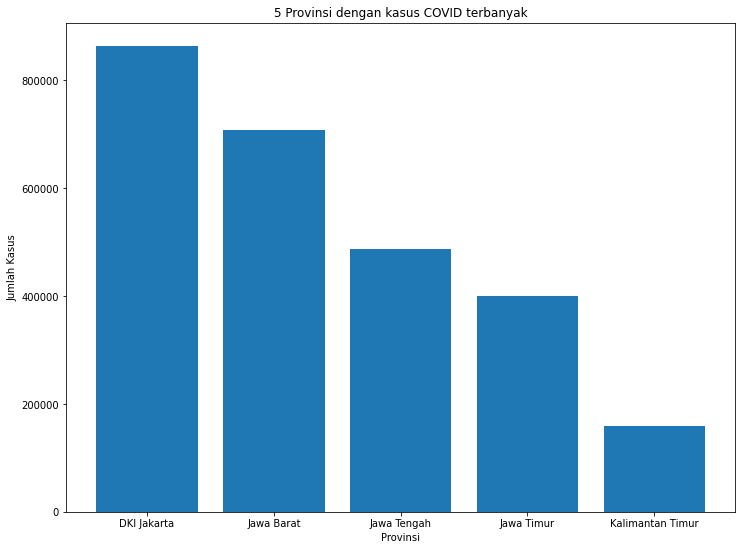

In [12]:
#menghitung jumlah provinsi dengan kasus terbanyak
plt.figure(figsize=(12,9))
plt.bar(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Location'].values[:5], 
        newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Total Cases'].values[:5])
plt.title('5 Provinsi dengan kasus COVID terbanyak', fontsize=12)
plt.xlabel('Provinsi')
plt.ylabel('Jumlah Kasus')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


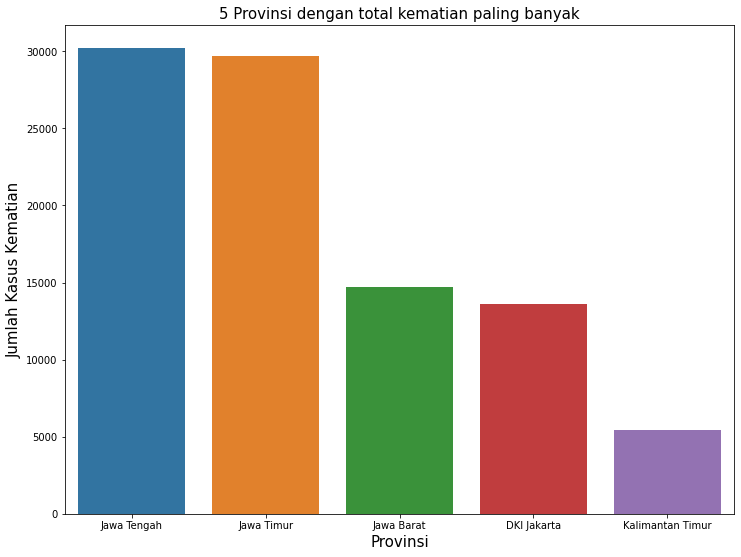

In [13]:
#Provinsi dengan angka kematian terbanyak
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], ascending=False)['Location'].values[:5],
            newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], ascending=False)['Total Deaths'].values[:5])
plt.title('5 Provinsi dengan total kematian paling banyak', fontsize=15)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Jumlah Kasus Kematian', fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


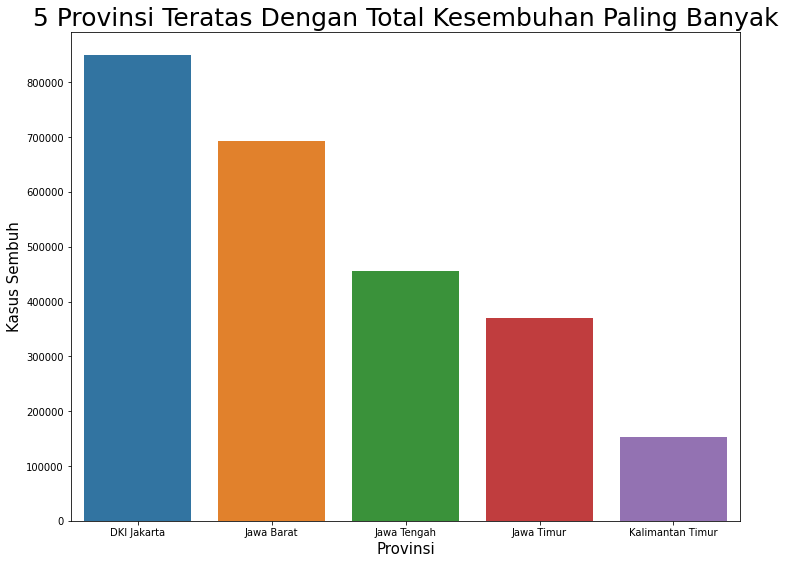

In [15]:
# Provinsi dengan Angka Kesembuhan Terbanyak
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Recovered'], ascending=False)['Location'].values[:5],
            newest[newest.Location != 'Indonesia'].sort_values(by=['Total Recovered'], ascending=False)['Total Recovered'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kesembuhan Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Kasus Sembuh', fontsize=15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


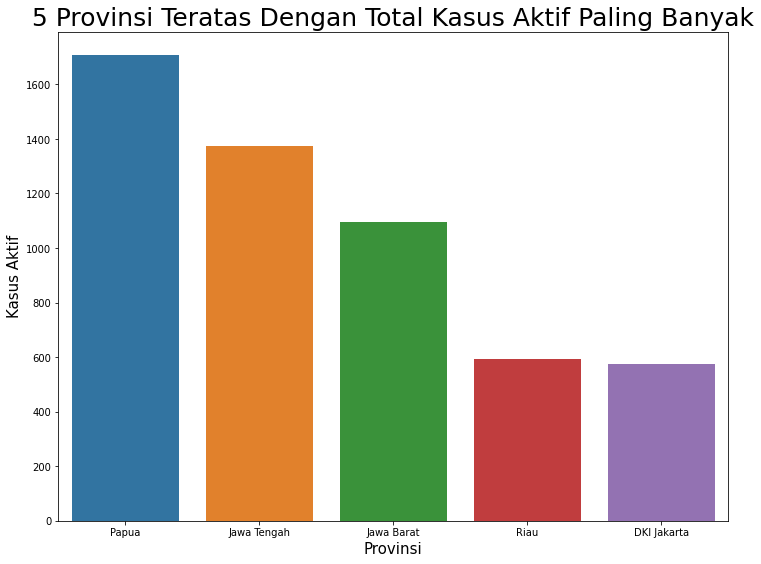

In [16]:
# Provinsi dengan Angka Kasus Aktif Terbanyak
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Active Cases'], ascending=False)['Location'].values[:5],
            newest[newest.Location != 'Indonesia'].sort_values(by=['Total Active Cases'], ascending=False)['Total Active Cases'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kasus Aktif Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Kasus Aktif', fontsize=15)
plt.show()

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
columnsToPlot = ['New Cases',	'New Deaths',	'New Recovered',	'New Active Cases',	
                 'Total Cases',	'Total Deaths',	'Total Recovered',	'Total Active Cases',	'New Cases per Million',	
                 'Total Cases per Million',	'New Deaths per Million',	'Total Deaths per Million',	
                 'Total Deaths per 100rb', 'Case Fatality Rate',	'Case Recovered Rate']

plotScale = 6
mpl.rcParams['figure.figsize'] = (5*plotScale, 4*plotScale)

listOfLocations = data1['Location'].unique()
numOfCol = 4

#kase bagi tiap baris 4 kolom
for locGroup in range(0, len(listOfLocations), numOfCol):
  #bekeng figure baru tiap baris
  fig = plt.figure(constrained_layout=False)

  #subfigure yang ba panjang ke kanan
  subplots = fig.subfigures(1,4)

  #listOfLocations[locGroup:locGroup + numOfCol]
  #maksudnya slice tu array listOfLocations, mulai dari index locGroup, sampe index locGroup + numOfCol
  #jadi nanti depe elemen maximum ada 4
  for idxLoc, location in enumerate(listOfLocations[locGroup:locGroup + numOfCol]):
    #filter data cuma for itu lokasi
    df1 = df[df['Location'] == location]
    df1.sort_values('Date')
    #bekeng subplot yang ba panjang ke bawah for mo se tunjung dpe graf
    ax = subplots[idxLoc].subplots(len(columnsToPlot), 1)

  #mulai enumerasi tiap nilai dari dataset, kong se muncul di graf satu satu
    #variabel 'ax' itu berupa list yang ada subaxes for torang mo plot akang graf
    for idxCol, (axes, columns) in enumerate(zip(ax, columnsToPlot)):
      #ba cit, bekeng supaya graf pertama se muncul title
      if idxCol == 0:
        axes.set_title(location)

    #plot graf di 'axes' itu
      axes.plot(df1[columns], label=columns)
      axes.get_xaxis().set_ticks([])
      axes.legend()

AttributeError: ignored

<Figure size 2160x1728 with 0 Axes>

In [20]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=data1['Date'],
                         y=data1['Total Cases'],
                         mode='lines',
                         name= 'Total Cases'
                        ))

fig.update_layout(title='Jumlah Kasus sampai pada Desember 2021',
                 template='plotly_white',
                 xaxis_title='Date',
                 yaxis_title='Total Cases'
                 )
fig.show()

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data1['Date'],
                         y=data1['New Cases'],
                         mode='lines',
                         name= 'Total Cases'
                        ))

fig.update_layout(title='Jumlah Kasus Baru sampai pada Desember 2021',
                 template='plotly_white',
                 xaxis_title='Date',
                 yaxis_title='Total Cases'
                 )
fig.show()

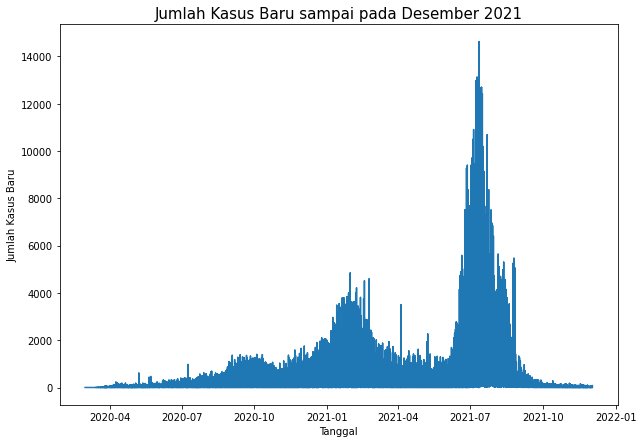

In [22]:
#Zooming trend kasus kematian Covid di DKI Jakarta di 7 hari terakhir (sampai 9 Juli 2021)
plt.figure(figsize=(10,7))
plt.plot(data1['Date'].values ,data1['New Cases'].values)
plt.title('Jumlah Kasus Baru sampai pada Desember 2021', fontsize=15)
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kasus Baru')
plt.show()

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data1['Date'],
                         y=data1['Total Active Cases'],
                         mode='lines',
                         name= 'Active Cases',
                         marker_color= 'red'
                         ))

fig.update_layout(title='Jumlah Kasus Aktif sampai pada Desember 2021',
                 template='plotly_white',
                 xaxis_title='Date',
                 yaxis_title='Total Cases'
                 )
fig.show()

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data1['Date'],
                         y=data1['New Deaths'],
                         mode='lines',
                         name='Death Cases',
                         marker_color='black'
                         #line=dict(dash='dot')
                        ))

fig.update_layout(title='Jumlah Kematian Baru sampai pada Desember 2021',
                 template='plotly_white',
                 xaxis_title='Date',
                 yaxis_title='Total Cases'
                 )
fig.show()

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data1['Date'],
                         y=data1['New Recovered'],
                         mode='lines',
                         name='Recovered Case',
                         marker_color='green'
                        ))

fig.update_layout(title='Jumlah Recovered Baru sampai pada Desember 2021',
                 template='plotly_white',
                 xaxis_title='Date',
                 yaxis_title='Total Cases'
                 )
fig.show()

In [26]:
newest['Date']

21364   2021-11-21
21617   2021-11-28
21700   2021-12-01
21712   2021-12-01
21714   2021-12-01
21716   2021-12-01
21722   2021-12-01
21730   2021-12-02
21731   2021-12-02
21732   2021-12-02
21733   2021-12-02
21734   2021-12-02
21736   2021-12-02
21737   2021-12-02
21738   2021-12-02
21739   2021-12-02
21740   2021-12-02
21741   2021-12-02
21742   2021-12-02
21743   2021-12-02
21744   2021-12-02
21745   2021-12-02
21746   2021-12-02
21747   2021-12-02
21748   2021-12-02
21749   2021-12-02
21750   2021-12-02
21751   2021-12-02
21752   2021-12-02
21753   2021-12-02
21754   2021-12-02
21755   2021-12-02
21756   2021-12-02
21757   2021-12-02
Name: Date, dtype: datetime64[ns]

In [27]:
#Highlight khusus DKI Jakarta
jakarta = data[data.Location == 'DKI Jakarta']
jakarta

Date     Location  New Cases  New Deaths  New Recovered  \
0     2020-03-01  DKI Jakarta          2           0              0   
1     2020-03-02  DKI Jakarta          2           0              0   
4     2020-03-03  DKI Jakarta          2           0              0   
8     2020-03-04  DKI Jakarta          2           0              0   
12    2020-03-05  DKI Jakarta          0           1              0   
...          ...          ...        ...         ...            ...   
21601 2021-11-28  DKI Jakarta         51           0             52   
21635 2021-11-29  DKI Jakarta         41           0             71   
21668 2021-11-30  DKI Jakarta         44           0              0   
21701 2021-12-01  DKI Jakarta         70           0              1   
21733 2021-12-02  DKI Jakarta         28           0              0   

       New Active Cases  Total Cases  Total Deaths  Total Recovered  \
0                     2           39            20               41   
1                     2           41            20               41   
4                     2           43            20               41   
8                     2           45            20               41   
12                   -1           45            21               41   
...                 ...          ...           ...              ...   
21601                -1       863862         13596           849803   
21635               -30       863903         13596           849874   
21668                44       863947         13596           849874   
21701                69       864017         13596           849875   
21733                28       864045         13596           849875   

       Total Active Cases Location Level  Area (km2)  Population  \
0                     -22       Province         664    10846145   
1                     -20       Province         664    10846145   
4                     -18       Province         664    10846145   
8                     -16       Province         664    10846145   
12                    -17       Province         664    10846145   
...                   ...            ...         ...         ...   
21601                 463       Province         664    10846145   
21635                 433       Province         664    10846145   
21668                 477       Province         664    10846145   
21701                 546       Province         664    10846145   
21733                 574       Province         664    10846145   

       Population Density   Longitude  Latitude  Total Deaths per 100rb  
0                16334.31  106.836118 -6.204699                    0.18  
1                16334.31  106.836118 -6.204699                    0.18  
4                16334.31  106.836118 -6.204699                    0.18  
8                16334.31  106.836118 -6.204699                    0.18  
12               16334.31  106.836118 -6.204699                    0.19  
...                   ...         ...       ...                     ...  
21601            16334.31  106.836118 -6.204699                  125.35  
21635            16334.31  106.836118 -6.204699                  125.35  
21668            16334.31  106.836118 -6.204699                  125.35  
21701            16334.31  106.836118 -6.204699                  125.35  
21733            16334.31  106.836118 -6.204699                  125.35  

[642 rows x 17 columns]

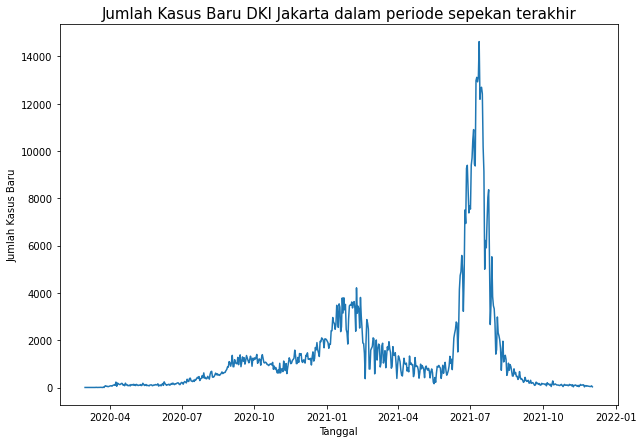

In [28]:
plt.figure(figsize=(10,7))
plt.plot(jakarta['Date'].values ,jakarta['New Cases'].values)
plt.title('Jumlah Kasus Baru DKI Jakarta dalam periode sepekan terakhir', fontsize=15)
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kasus Baru')
plt.show()

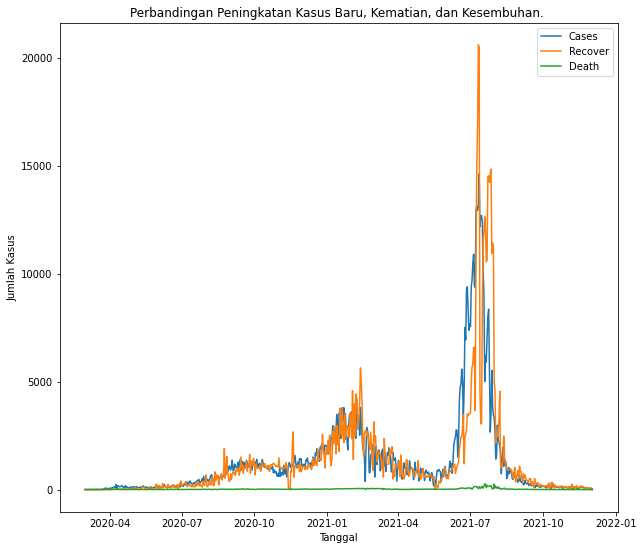

In [29]:
# Perbandingan Peningkatan Kasus Baru, Kematian, dan Kesembuhan
plt.figure(figsize=(10,9))
plt.plot(jakarta['Date'].values ,jakarta['New Cases'].values, label='Cases')
plt.plot(jakarta['Date'].values, jakarta['New Recovered'].values, label = 'Recover')
plt.plot(jakarta['Date'].values, jakarta['New Deaths'].values, label = 'Death')
plt.title('Perbandingan Peningkatan Kasus Baru, Kematian, dan Kesembuhan. ')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Kasus')
plt.legend()
plt.show()

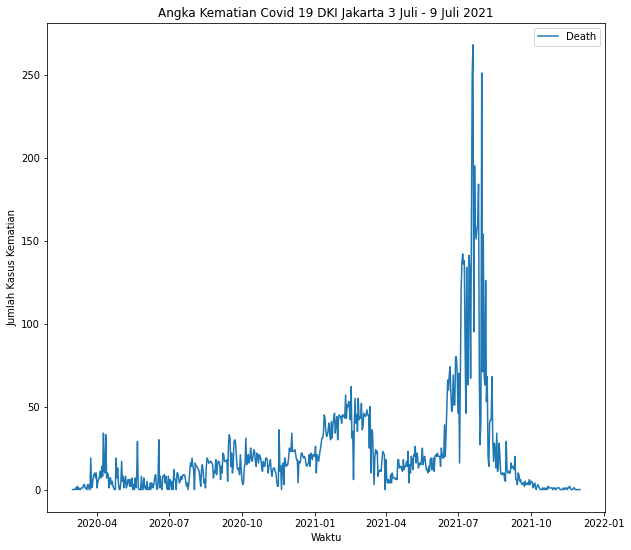

In [30]:
# Angka Kematian Covid 19 DKI Jakarta sampai Des 2021
plt.figure(figsize=(10,9))
plt.plot(jakarta['Date'].values, jakarta['New Deaths'].values, label = 'Death')
plt.title('Angka Kematian Covid 19 DKI Jakarta 3 Juli - 9 Juli 2021')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Kasus Kematian')
plt.legend()
plt.show()

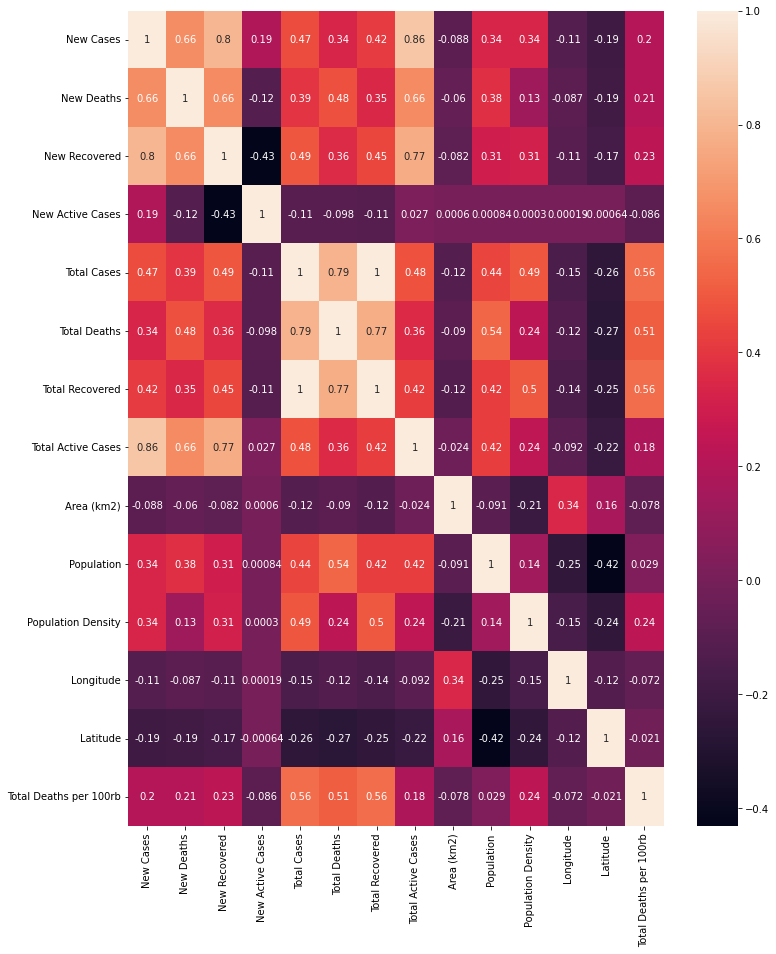

In [33]:
#Melihat korelasi antar variabel dalam suatu heatmap
plt.figure(figsize=(12,15))
sns.heatmap(data1.corr(), annot=True)
plt.show()

In [34]:
data1.head()

Date     Location  New Cases  New Deaths  New Recovered  \
0 2020-03-01  DKI Jakarta          2           0              0   
1 2020-03-02  DKI Jakarta          2           0              0   
3 2020-03-02         Riau          1           0              0   
4 2020-03-03  DKI Jakarta          2           0              0   
6 2020-03-03   Jawa Barat          1           1              0   

   New Active Cases  Total Cases  Total Deaths  Total Recovered  \
0                 2           39            20               41   
1                 2           41            20               41   
3                 1            2             0                3   
4                 2           43            20               41   
6                 0            1             1                8   

   Total Active Cases Location Level  Area (km2)  Population  \
0                 -22       Province         664    10846145   
1                 -20       Province         664    10846145   
3                  -1       Province       87024     6074100   
4                 -18       Province         664    10846145   
6                  -8       Province       35378    45161325   

   Population Density   Longitude  Latitude  Total Deaths per 100rb  
0            16334.31  106.836118 -6.204699                    0.18  
1            16334.31  106.836118 -6.204699                    0.18  
3               69.80  101.805109  0.511648                    0.00  
4            16334.31  106.836118 -6.204699                    0.18  
6             1276.55  107.603708 -6.920432                    0.00

In [35]:
#Memfokuskan pada beberapa variable saja yang terkait dengan kasus Covid 19
data2 = data1[['New Deaths', 'New Cases','Total Cases', 
               'New Recovered', 'Total Recovered', 'Total Deaths',
               'Population', 'Population Density']]
data2.head()

New Deaths  New Cases  Total Cases  New Recovered  Total Recovered  \
0           0          2           39              0               41   
1           0          2           41              0               41   
3           0          1            2              0                3   
4           0          2           43              0               41   
6           1          1            1              0                8   

   Total Deaths  Population  Population Density  
0            20    10846145            16334.31  
1            20    10846145            16334.31  
3             0     6074100               69.80  
4            20    10846145            16334.31  
6             1    45161325             1276.55

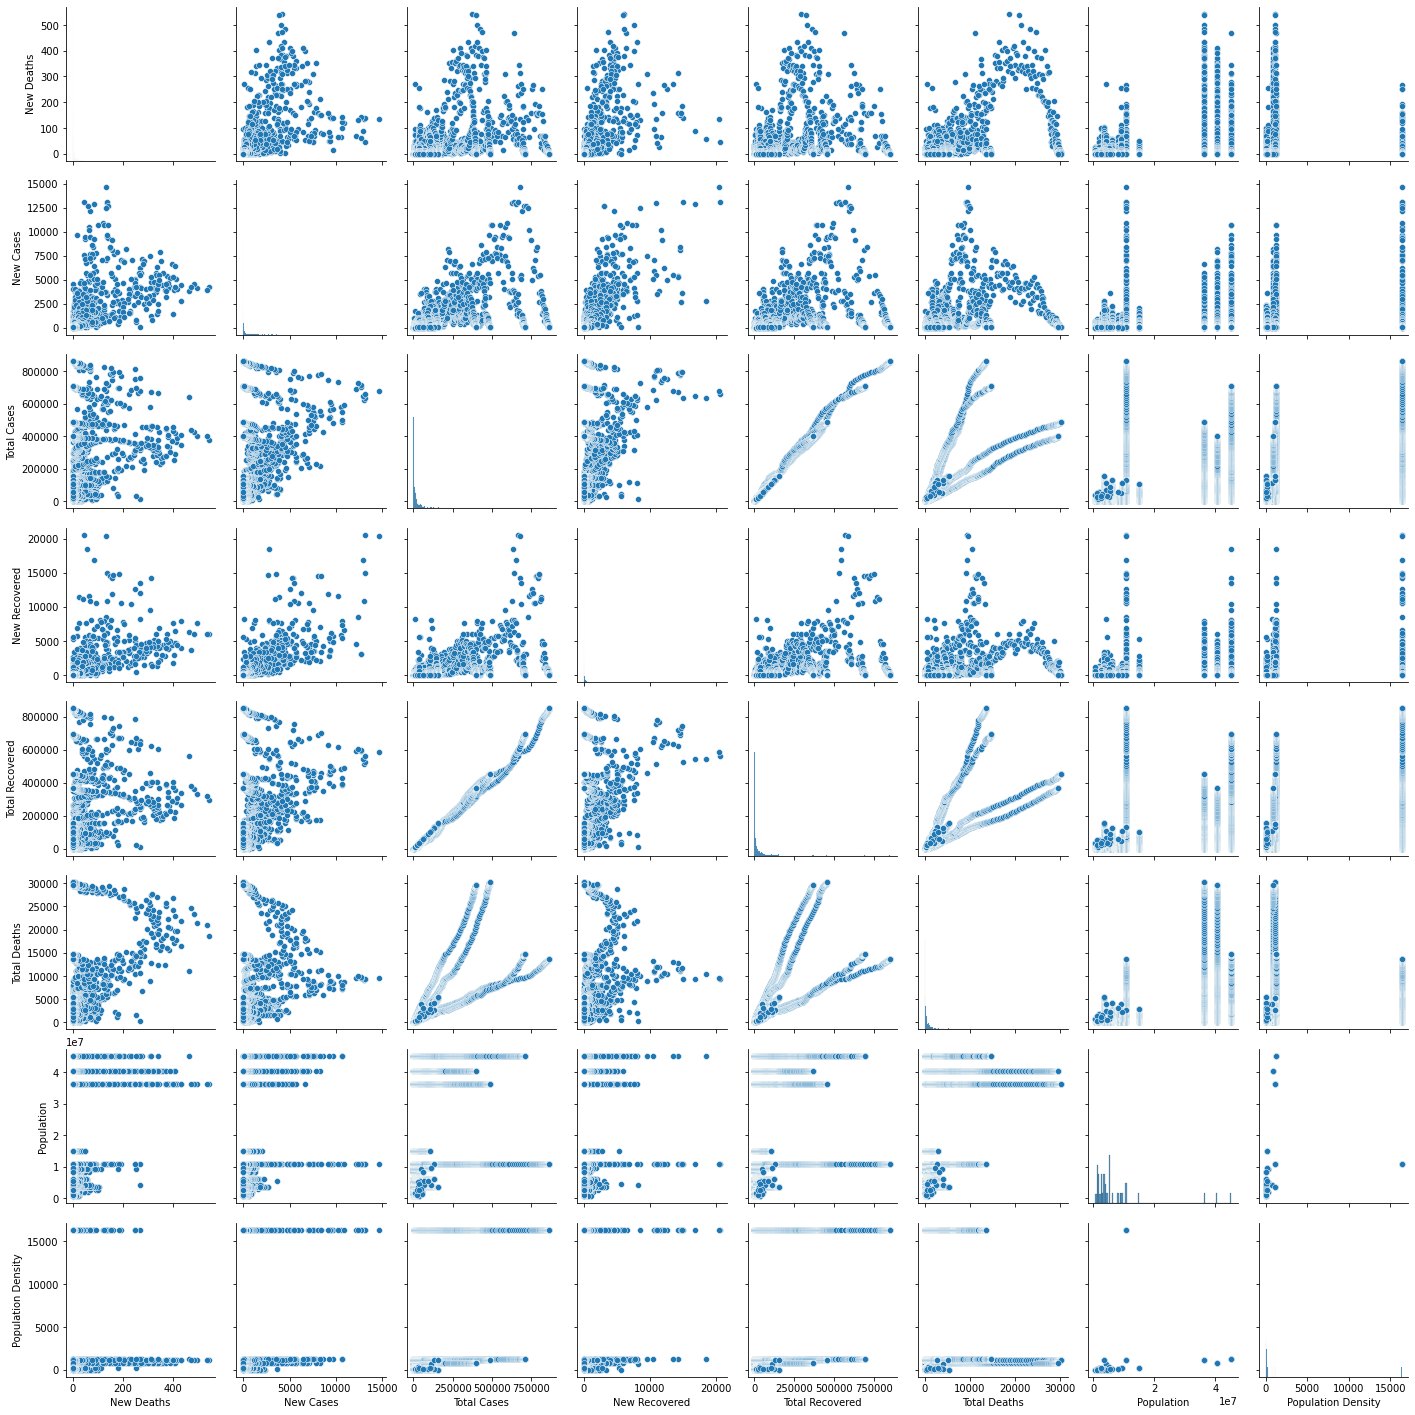

In [37]:
#Melihat korelasi antar variabel dari sebaran data pada scatter plot 
sns.pairplot(data2)
plt.show()